In [24]:
import yfinance as yf

start_date = '2009-01-01'
end_date = '2019-01-01'

# Fetch S&P 500 and NASDAQ data from Yahoo Finance 
sp500_data = yf.download('^GSPC', start = start_date, end = end_date, interval='1wk' )
nasdaq_data = yf.download('^IXIC', start = start_date, end = end_date, interval='1wk' )

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [25]:
# Print the first few rows and summary statistics of the data
print("S&P 500")
print(sp500_data['Adj Close'].head(), end='\n\n')

print("Statistics")
print(sp500_data['Adj Close'].describe(), end='\n\n')

S&P 500
Date
2009-01-01    906.650024
2009-01-08    842.619995
2009-01-15    840.239990
2009-01-22    874.090027
2009-01-29    832.229980
Name: Adj Close, dtype: float64

Statistics
count     522.000000
mean     1767.613853
std       565.919738
min       712.869995
25%      1280.150055
50%      1814.955017
75%      2122.390015
max      2925.510010
Name: Adj Close, dtype: float64



In [26]:
print("NASDAQ")
print(nasdaq_data['Adj Close'].head(), end='\n\n')

print("Statistics")
print(nasdaq_data['Adj Close'].describe(), end='\n\n')

NASDAQ
Date
2009-01-01    1599.060059
2009-01-08    1489.640015
2009-01-15    1507.069946
2009-01-22    1558.339966
2009-01-29    1515.050049
Name: Adj Close, dtype: float64

Statistics
count     522.000000
mean     4140.000216
std      1723.083660
min      1353.739990
25%      2694.377563
50%      4068.864990
75%      5123.017700
max      8109.689941
Name: Adj Close, dtype: float64



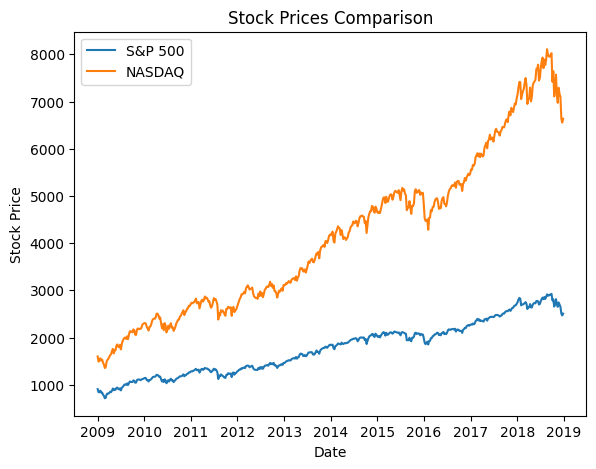

In [27]:
import matplotlib.pyplot as plt

# Plot S&P500 and NASDAQ stock prices over the years 
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(sp500_data['Adj Close'] , label='S&P 500')
ax1.plot(nasdaq_data['Adj Close'] , label='NASDAQ')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')
ax1.set_title('Stock Prices Comparison')
plt.legend()
plt.show()

In [28]:
import pandas as pd
import numpy as np
import requests

# Set the API key and base URL
api_key = "349fd5c8bc01100b37528a346fbf4371"
base_url = "https://api.stlouisfed.org/fred/series/observations"

# Fetch the risk-free rate, inflation rate, risk premium, and GDP growth rate from FRED
factors = {
    "rf_rate" : {
        "series_id": "DGS5",
        "units" : "lin",
        "frequency" : "w"
    },
    "inflation_rate" : {
        "series_id": "T5YIE",
        "units" : "pch",
        "frequency": "w"
    },
    "risk_premium" : {
        "series_id": "TENEXPCHAREARISPRE",
        "units" : "pch",
        "frequency": "m"
    },
    "gdp_growth" : {
        "series_id": "GDPC1",
        "units" : "pch",
        "frequency": "q"
    }
}

# Fetch the data for each factor
for factor, data in factors.items():
    response = requests.request("GET", base_url, params = {
        "api_key" : api_key,
        "series_id" : data['series_id'],
        "file_type" : "json",
        "observation_start" : start_date,
        "observation_end" : end_date,
        "units" : data['units'],
        "frequency" : data['frequency']
    } )

    # Convert the response to a DataFrame
    factors[factor] = pd.DataFrame.from_dict(response.json()['observations'])[["date", "value"]]
    factors[factor]['date'] = pd.to_datetime(factors[factor]['date'])
    factors[factor]['value'] = factors[factor]['value'].replace('.', np.nan)
    factors[factor] = factors[factor].dropna()
    factors[factor].set_index('date', inplace=True)
    
    # Convert the values to numeric and change percentage to decimal
    factors[factor]['value'] = pd.to_numeric(factors[factor]['value']).astype(float)/100
    
    # Reindex the data to match the S&P 500 data
    factors[factor] = factors[factor].reindex(sp500_data.index, method='ffill')

In [29]:
# Calculate the returns and excess returns for S&P 500 and NASDAQ
sp500_data['Returns'] = sp500_data['Adj Close'].pct_change()
nasdaq_data['Returns'] = nasdaq_data['Adj Close'].pct_change()

sp500_data['Excess_Returns'] = sp500_data['Returns'] - factors['rf_rate']['value']
nasdaq_data['Excess_Returns'] = nasdaq_data['Returns'] - factors['rf_rate']['value']


# Create a DataFrame with the factors data
factors_data = pd.DataFrame({
    'rf_rate': factors['rf_rate']['value'],
    'inflation_rate': factors['inflation_rate']['value'],
    'risk_premium': factors['risk_premium']['value'],
    'gdp_growth': factors['gdp_growth']['value']
}, index=sp500_data.index)

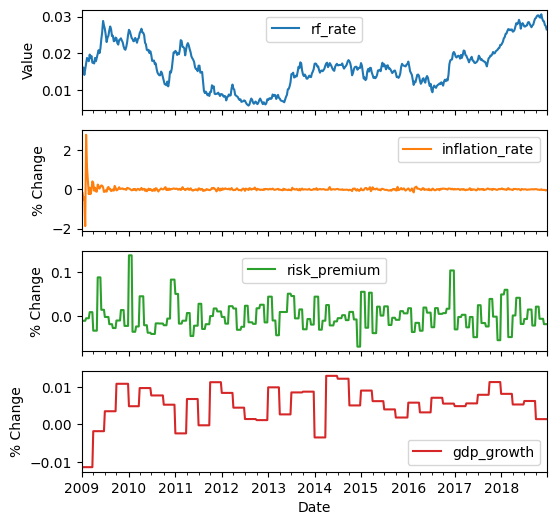

In [30]:
factors_plot = factors_data.plot( subplots=True, figsize=(6, 6))
y_labels = ['Value', '% Change', '% Change', '% Change']
for factor_plot, label in zip(factors_plot, y_labels):
    factor_plot.set_ylabel(label)

In [31]:
import statsmodels.api as sm

# Ensure all datasets align in terms of dates
combined_data = pd.concat([sp500_data['Excess_Returns'].rename('S&P500'), nasdaq_data['Excess_Returns'].rename('NASDAQ'), factors_data], axis=1).dropna()

# Set up the independent (X) and dependent (Y) variables
X = combined_data[[ 'inflation_rate', "risk_premium", "gdp_growth"]]
Y_1 = combined_data['S&P500']  
Y_2 = combined_data['NASDAQ']

# Add a constant term for the regression (intercept)
X = sm.add_constant(X)

In [32]:
# Fit the OLS regression model for S&P 500
model_1 = sm.OLS(Y_1, X).fit()

# Print the results of the regression for S&P 500
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 S&P500   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9952
Date:                Fri, 27 Sep 2024   Prob (F-statistic):              0.395
Time:                        04:48:39   Log-Likelihood:                 1246.5
No. Observations:                 521   AIC:                            -2485.
Df Residuals:                     517   BIC:                            -2468.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0161      0.001    -10.

In [33]:
# Fit the OLS regression model for NASDAQ
model_2 = sm.OLS(Y_2, X).fit()

# Print the results of the regression for NASDAQ
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 NASDAQ   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5049
Date:                Fri, 27 Sep 2024   Prob (F-statistic):              0.679
Time:                        04:48:39   Log-Likelihood:                 1191.1
No. Observations:                 521   AIC:                            -2374.
Df Residuals:                     517   BIC:                            -2357.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0148      0.002     -9.